This section involves controlling the actual Lorenz System and forcing it into certain desired states using an Echo State Network to model its trajectory.

In [1]:
!git clone https://github.com/cknd/pyESN.git

Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 1.17 MiB | 8.65 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
#!pip install nolds
!pip install tqdm

In [3]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#import nolds
from sklearn import preprocessing
from mpl_toolkits import mplot3d
from scipy.interpolate import splprep, splev
import math

from tqdm import tqdm


In [4]:
'''

Echo State Network model for reservoir computing

'''




def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))


In [5]:
'''

Set of several chaos metrics to characterize the visualized chaotic system

'''


def chaos_metrics(data):
  h = nolds.hurst_rs(data)
  rl = nolds.lyap_r(data)
  el = nolds.lyap_e(data)
  fd = nolds.corr_dim(data, 1)
  entropy = nolds.sampen(data)

  print("Hurst from nolds custom library", h)
  print("Rosenstein Lyapunov estimation from nolds custom library", rl)
  print("Eckmann Lyapunov estimation from nolds custom library", el)
  print("Fractal Dimension from nolds library", fd)
  print("Entropy from nolds library", entropy)

In [6]:
'''

For ESN model. Trains the model on the most current data - window, then predicts on the current data point

Input : model (esn), training data, training output data, actual input for prediction
Output : Prediction from the model

'''

def get_prediction(model, train_input, train_output, actual_input):
  model.fit(np.array(train_input), np.array(train_output))
  return model.predict(actual_input)





In [7]:
'''

Functions for Lorenz system

Inputs : A set of values and hyperparameters
Outputs : The derivatives of the system defined by the lorenz function

'''
def Lorenz_System(x, y, z, dt, sig, p, b):

  dx = (sig*(y-x)) * dt
  dy = (x*(p - z)-y) * dt
  dz = (x*y - b*z) * dt


  return [x+dx, y+dy, z+dz]


def generate_points(function, initial_conditions=[.01, 0, 0],h=.01,N=1000,hyper_parameters=[10, 28, 8/3]):

  t_values = list(range(0, int(N), 1))
  t_values_scaled =  [h*x for x in t_values]
  values = []


  for t in t_values_scaled:
    if t == t_values_scaled[0]:
      point = function(initial_conditions[0], initial_conditions[1], initial_conditions[2], h,hyper_parameters[0], hyper_parameters[1], hyper_parameters[2])
      new_point = point
      values.append(new_point)
    else:
      new_point = function(new_point[0], new_point[1], new_point[2], h, hyper_parameters[0],hyper_parameters[1],hyper_parameters[2])
      values.append(new_point)
  return values

First we generate points for an initial system X and system Y. Our goal is to take system Y -> X. We will accomplish this by first training the Echo State Network on the window size of data for system X, then use that to predict the next time step in system X. This is the predict for time t, using data from t0, where t > t0. This predicted value will be used to create u(t) -> our control variable. We will calculate the control force F, by F(t) = K(u(t)-v(t)), where v(t) is our system Y at time t, and K is the scaling constant.

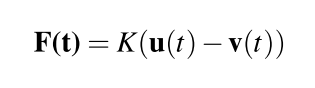

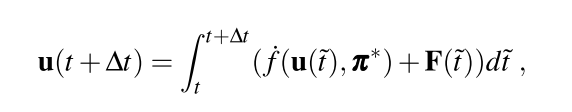

In [8]:
window = 102
hyper_parameters_initial = [2, 5, 2/3]
hyper_parameters_final = [20, 25, 8/3]

initial_conditions = [0.01, 0, 0]
N = 5000.0
h = .01

K = 1

#Mean squared error
mse = 0
mse_length = 0

predictions = []

tuned_esn = ESN(n_inputs = 3,
                n_outputs = 3,
                n_reservoir = 300,
                sparsity=.2,
                random_state=42,
                spectral_radius = .5,
                noise=.0003)

#Generate Points

system_x = generate_points(function=Lorenz_System, initial_conditions=initial_conditions,h=h,N=1000,hyper_parameters=hyper_parameters_initial)
system_x = preprocessing.scale(system_x)

system_y = generate_points(function=Lorenz_System, initial_conditions=initial_conditions,h=h,N=1000,hyper_parameters=hyper_parameters_final)
system_y = preprocessing.scale(system_y)

values = []


# Initial training



#tuned_esn.fit(np.array(system_x[0:-1]), np.array(system_x[1:]))

u_new_t = np.array([0.0, 0.0,0.0])
F_t = np.array([0.0, 0.0,0.0])

for t in tqdm(range(window+1, len(system_x) - 1)):

  # Train model with x_in and y_out, and predict using the latest value x_a
  x_in = np.array(system_x[t-window:t-1])
  y_out = np.array(system_x[t-window+1:t])
  x_a = np.array(system_x[t])
  x_a = np.reshape(x_a, (1, x_a.shape[0]))

  # Train model on t0 data to get v(t)
  tuned_esn.fit(x_in, y_out)

  v_t = tuned_esn.predict(x_a)[0]
  predictions.append(v_t)
  u_t = system_y[t+1]



  F_t[0] = K*(u_t[0]-v_t[0])
  F_t[1] = K*(u_t[1]-v_t[1])
  F_t[2] = K*(u_t[2]-v_t[2])

  u_new_t[0] = u_t[0] - F_t[0]
  u_new_t[1] = u_t[1] - F_t[1]
  u_new_t[2] = u_t[2] - F_t[2]


  values.append(np.array(u_new_t))


100%|██████████| 896/896 [00:47<00:00, 18.71it/s]


Visualize Results

In [9]:
'''

Break down values list into x,y,z values for System Y

in green

'''
t_values_orig = []
x_values_orig = []
y_values_orig = []
z_values_orig = []

for i in range(5, len(system_y)):
  t_values_orig.append(i)
  x_values_orig.append(system_y[i][0])
  y_values_orig.append(system_y[i][1])
  z_values_orig.append(system_y[i][2])

t_values = np.array(t_values_orig)

In [10]:
'''

Break down values list into x,y,z values

in blue

'''
t_values = []
x_values = []
y_values = []
z_values = []

for i in range(5, len(values)):
  t_values.append(i)
  x_values.append(values[i][0])
  y_values.append(values[i][1])
  z_values.append(values[i][2])

t_values = np.array(t_values)

In [11]:
'''

Break down values list into x,y,z values

in red

'''
t_values_prediction = []
x_values_prediction = []
y_values_prediction = []
z_values_prediction = []

for i in range(5, len(predictions)):
  t_values_prediction.append(i)
  x_values_prediction.append(predictions[i][0])
  y_values_prediction.append(predictions[i][1])
  z_values_prediction.append(predictions[i][2])

t_values = np.array(t_values_prediction)

Plotted is original System Y

<ipython-input-16-9027c58ea1ec>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_new_orig, y_new_orig, z_new_orig, 'b-', label='Original',  linewidth=0.5, color='green')


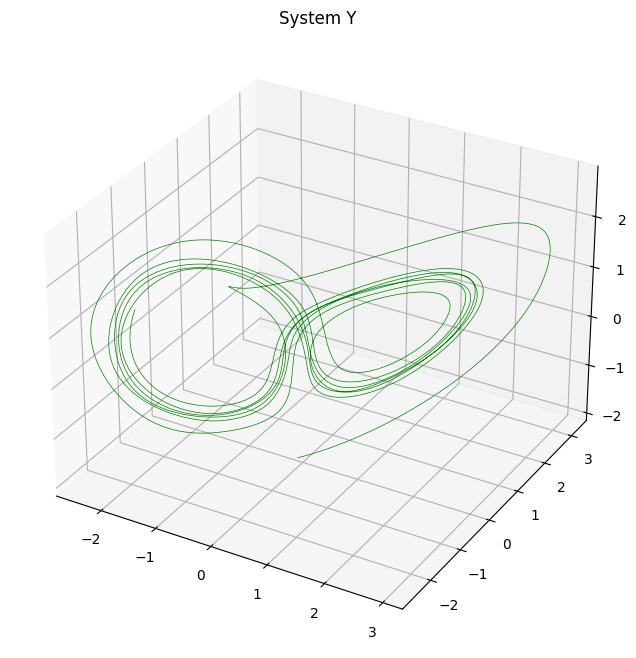

In [16]:
'''

3D Plot of the Lorenz System vs 3D Plot of Prediction

'''


tck, u = splprep([x_values_orig, y_values_orig, z_values_orig], s=1)
u_new = np.linspace(0, 1, len(t_values_orig))

x_new_orig, y_new_orig, z_new_orig = splev(u_new, tck)

tck, u = splprep([x_values, y_values, z_values], s=1)
u_new = np.linspace(0, 1, len(t_values))

x_new, y_new, z_new = splev(u_new, tck)

tck_prediction, u_prediction = splprep([x_values_prediction, y_values_prediction, z_values_prediction], s=1)
u_new_prediction = np.linspace(0, 1, len(t_values_prediction))

x_new_prediction, y_new_prediction, z_new_prediction = splev(u_new_prediction, tck_prediction)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', title='System Y')
ax.plot(x_new_orig, y_new_orig, z_new_orig, 'b-', label='Original',  linewidth=0.5, color='green')


Original System X

<ipython-input-13-2cd6121c5305>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_new, y_new, z_new, 'b-', label='Actual',  linewidth=0.5, color='blue')


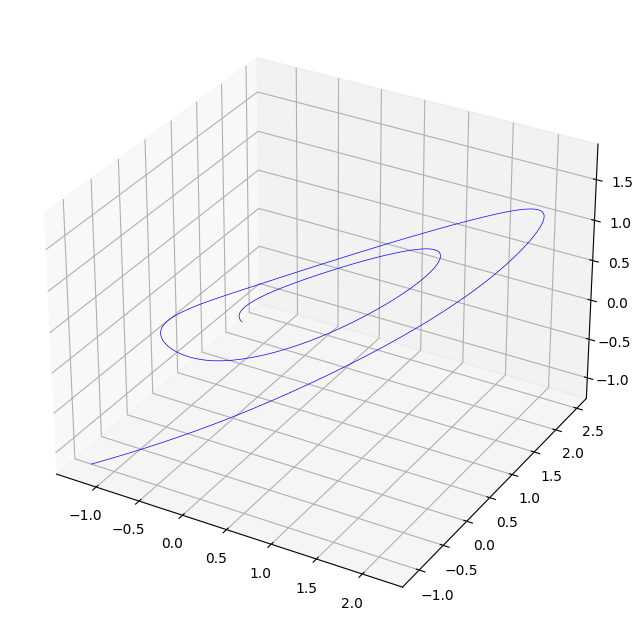

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', title='System X')
ax.plot(x_new, y_new, z_new, 'b-', label='Actual',  linewidth=0.5, color='blue')

System Y after force applied calcuted using System X

<ipython-input-14-e338bbef391c>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_new_prediction, y_new_prediction, z_new_prediction, 'b-', label='Prediction',  linewidth=0.5, color='red')


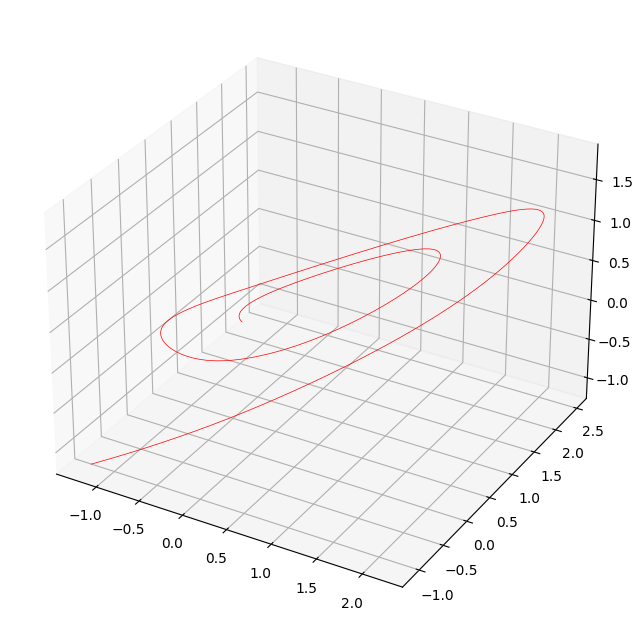

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', title='System X')
ax.plot(x_new_prediction, y_new_prediction, z_new_prediction, 'b-', label='Prediction',  linewidth=0.5, color='red')